In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.integrate import ode
import numpy as np

# Qubit Readout Simulation

Suppose the system consisting of a transmon and a readout resonator coupled in the dispersive regime. A transmission line couples with the resonator, whereby an operator can send input signals to the system and receive the transmitted waveform.

This notebook will simulate the emission of an input signal $s_{in}(t)$ along the transmission line, its interaction with the readout reasonator and the analysis of the transmitted waveform $s_{out}(t)$.

### Input Signal

In [109]:
# Frequency mismatch between readout pulse and cavity (Hz)
f_mm = 1e6
    
def b_in(t):

    # Pulse start time
    t0 = 100e-9
    
    # Pulse stop time
    tf = 2500e-9
    
    if t > t0 and t < tf:
        return 1*np.exp(1j*2*np.pi*f_mm*t)

    else:
        return 0 

### System evolution

In [110]:
g = 45e6 # Transmon-cavity coupling strength (Hz)
delta = 380e6 # Transmon-cavity detuning (0z)
chi = g**2/delta

kappa = chi

In [111]:
def eom_resonator(t, alpha, q_state, kappa, chi, b_in):
    return (1j*(-1)**q_state*chi/2 - kappa/2)*alpha - 1j*kappa**0.5*b_in(t)

t1 = 47530e-10   # > 20/chi
dt = 1e-10
Ndt = int(t1/dt) + 1
t_rng = [x*10**6 for x in np.linspace(0, t1, Ndt)]    # Time in microseconds
alpha0 = 0    # Initial cavity state

q_state = 0    # Transmon in ground state

rg = ode(eom_resonator)
rg.set_integrator('zvode', method = 'bdf').set_initial_value(alpha0, 0).set_f_params(q_state, kappa, chi, b_in)
alpha_g = []
while rg.successful() and rg.t < t1:
    alpha_g.append(rg.integrate(rg.t + dt))

b_out_g = [-1j*kappa**0.5*alpha_g[x] + b_in(dt*x) for x in range(len(alpha_g))]
    

q_state = 1    # Transmon in excited state

re = ode(eom_resonator)
re.set_integrator('zvode', method = 'bdf').set_initial_value(alpha0, 0).set_f_params(q_state, kappa, chi, b_in)
alpha_e = []
while re.successful() and re.t < t1:
    alpha_e.append(re.integrate(re.t + dt))

b_out_e = [-1j*kappa**0.5*alpha_e[x] + b_in(dt*x) for x in range(len(alpha_e))]

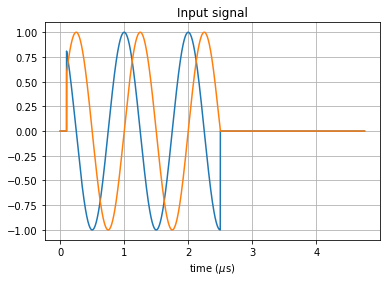

In [124]:
fig, ax = plt.subplots()

ax.plot(t_rng, [b_in(dt*x).real for x in range(len(alpha_g))])
ax.plot(t_rng, [b_in(dt*x).imag for x in range(len(alpha_g))])
ax.set_xlabel('time ($\mu$s)')
ax.set_title('Input signal')
ax.grid()

plt.show()

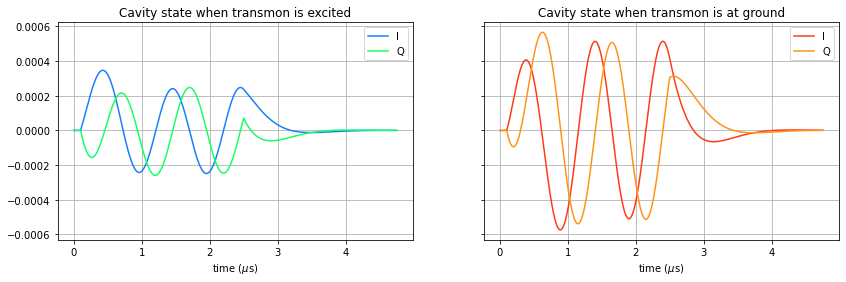

In [123]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(14,4))

ax1.plot(t_rng, [x.real for x in alpha_e], label = 'I', c = '#177FFF')
ax1.plot(t_rng, [x.imag for x in alpha_e], label = 'Q', c = '#17FF64')
ax1.set_xlabel('time ($\mu$s)')
ax1.set_title('Cavity state when transmon is excited')
ax1.grid()
ax1.legend()

ax2.plot(t_rng, [x.real for x in alpha_g], label = 'I', c = '#FF3A17')
ax2.plot(t_rng, [x.imag for x in alpha_g], label = 'Q', c = '#FF9317')
ax2.set_xlabel('time ($\mu$s)')
ax2.set_title('Cavity state when transmon is at ground')
ax2.grid()
ax2.legend()

plt.show()

### Output signal

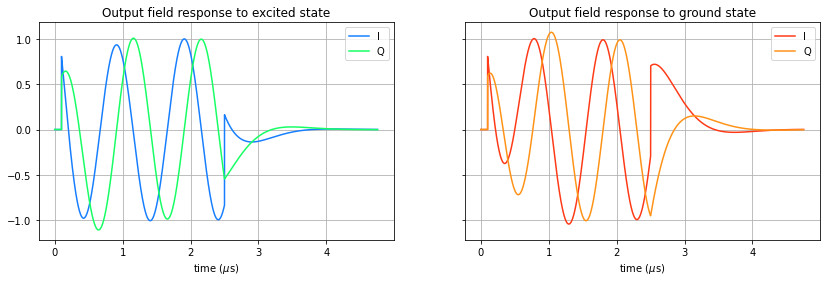

In [122]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(14,4))

ax1.plot(t_rng, [x.real for x in b_out_e], label = 'I', c = '#177FFF')
ax1.plot(t_rng, [x.imag for x in b_out_e], label = 'Q', c = '#17FF64')
ax2.plot(t_rng, [x.real for x in b_out_g], label = 'I', c = '#FF3A17')
ax2.plot(t_rng, [x.imag for x in b_out_g], label = 'Q', c = '#FF9317')

ax1.set_xlabel('time ($\mu$s)')
ax1.set_title('Output field response to excited state')
ax1.grid()
ax1.legend()

ax2.set_xlabel('time ($\mu$s)')
ax2.set_title('Output field response to ground state')
ax2.grid()
ax2.legend()

plt.show()

### Data acquisition

In [115]:
tau_wd = 5/kappa    # waiting time
tau_s = 1400e-9    # sampling time
dtau = 1e-9    # sampling interval
Ntau = int(tau_s/dtau)    # number of samples

# Collecting samples from the output signal
start_index = t_rng.index(sorted(t_rng, key = lambda x: (tau_wd*1e6-x)**2)[0])
dindex = int(dtau/dt)
end_index = t_rng.index(sorted(t_rng, key = lambda x: ((tau_wd + tau_s)*1e6-x)**2)[0])

acq_out_e = []
acq_out_g = []
acq_time = []    # microseconds
for n in range(Ntau):
    sampling_index = start_index + n*dindex
    acq_out_e.append(b_out_e[sampling_index])
    acq_out_g.append(b_out_g[sampling_index])
    acq_time.append(t_rng[sampling_index])

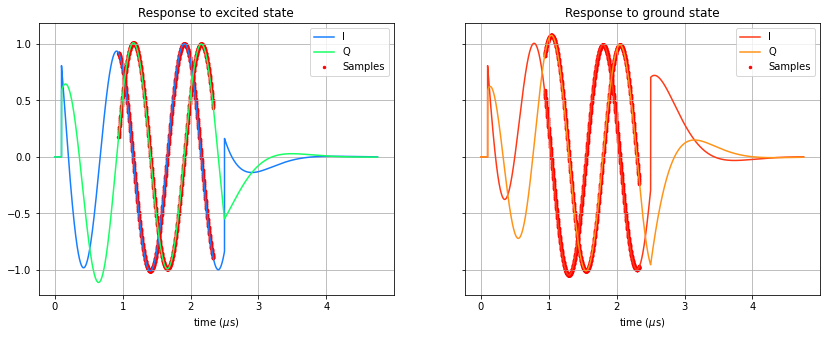

In [131]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(14,5))

ax1.plot(t_rng, [x.real for x in b_out_e], label = 'I', c = '#177FFF')
ax1.plot(t_rng, [x.imag for x in b_out_e], label = 'Q', c = '#17FF64')
ax1.scatter(acq_time, [x.real for x in acq_out_e], c = 'r', label = 'Samples', s = 6)
ax1.scatter(acq_time, [x.imag for x in acq_out_e], c = 'r', s = 6)

ax2.plot(t_rng, [x.real for x in b_out_g], label = 'I', c = '#FF3A17')
ax2.plot(t_rng, [x.imag for x in b_out_g], label = 'Q', c = '#FF9317')
ax2.scatter(acq_time, [x.real for x in acq_out_g], c = 'r', label = 'Samples', s = 6)
ax2.scatter(acq_time, [x.imag for x in acq_out_g], c = 'r', s = 6)

ax1.set_xlabel('time ($\mu$s)')
ax1.set_title('Response to excited state')
ax1.grid()
ax1.legend()

ax2.set_xlabel('time ($\mu$s)')
ax2.set_title('Response to ground state')
ax2.grid()
ax2.legend()

plt.show()

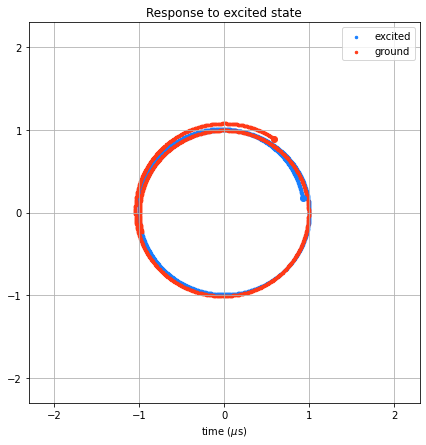

In [137]:
f, ax = plt.subplots(figsize=(7,7))

ax.scatter([x.real for x in acq_out_e], [x.imag for x in acq_out_e], label = 'excited', c = '#177FFF', s = 6)
ax.scatter([x.real for x in acq_out_g], [x.imag for x in acq_out_g], label = 'ground', c = '#FF3A17', s = 6)
ax.scatter([x.real for x in acq_out_e][0], [x.imag for x in acq_out_e][0], c = '#177FFF')
ax.scatter([x.real for x in acq_out_g][0], [x.imag for x in acq_out_g][0], c = '#FF3A17')

ax.set_ylim([-2.3, 2.3])
ax.set_xlim([-2.3, 2.3])
ax.set_xlabel('time ($\mu$s)')
ax.set_title('Response to excited state')
ax.legend()
ax.grid()

plt.show()

### Digital Signal Processing

phase_e: 11.21°
phase_g: 50.64°


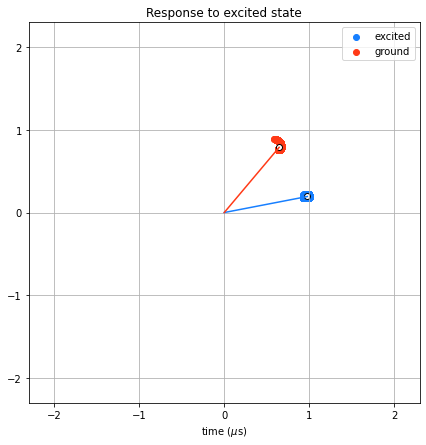

In [140]:
f, ax = plt.subplots(figsize=(7,7))

proc_out_e = [x*np.exp(-1j*2*np.pi*f_mm*dtau*n) for n, x in enumerate(acq_out_e)]
proc_out_g = [x*np.exp(-1j*2*np.pi*f_mm*dtau*n) for n, x in enumerate(acq_out_g)]
avg_e = np.mean(proc_out_e)
avg_g = np.mean(proc_out_g)

ax.scatter([x.real for x in proc_out_e], [x.imag for x in proc_out_e], label = 'excited', c = '#177FFF')
ax.scatter([x.real for x in proc_out_g], [x.imag for x in proc_out_g], label = 'ground', c = '#FF3A17')

ax.plot([0, avg_e.real], [0, avg_e.imag], c = '#177FFF')
ax.scatter([avg_e.real], [avg_e.imag], edgecolors = 'k', c = 'w')

ax.plot([0, avg_g.real], [0, avg_g.imag], c = '#FF3A17')
ax.scatter([avg_g.real], [avg_g.imag], edgecolors = 'k', c = 'w')

ax.set_ylim([-2.3, 2.3])
ax.set_xlim([-2.3, 2.3])
ax.set_xlabel('time ($\mu$s)')
ax.set_title('Response to excited state')
ax.legend()
ax.grid()

print('phase_e: %.2f°' % np.angle(avg_e, deg = True))
print('phase_g: %.2f°' % np.angle(avg_g, deg = True))
plt.show()

### State distinction

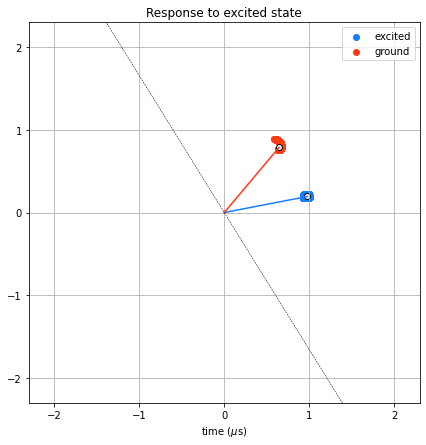

In [149]:
f, ax = plt.subplots(figsize=(7,7))

proc_out_e = [x*np.exp(-1j*2*np.pi*f_mm*dtau*n) for n, x in enumerate(acq_out_e)]
proc_out_g = [x*np.exp(-1j*2*np.pi*f_mm*dtau*n) for n, x in enumerate(acq_out_g)]
avg_e = np.mean(proc_out_e)
avg_g = np.mean(proc_out_g)

ax.scatter([x.real for x in proc_out_e], [x.imag for x in proc_out_e], label = 'excited', c = '#177FFF')
ax.scatter([x.real for x in proc_out_g], [x.imag for x in proc_out_g], label = 'ground', c = '#FF3A17')

ax.plot([0, avg_e.real], [0, avg_e.imag], c = '#177FFF')
ax.scatter([avg_e.real], [avg_e.imag], edgecolors = 'k', c = 'w')

ax.plot([0, avg_g.real], [0, avg_g.imag], c = '#FF3A17')
ax.scatter([avg_g.real], [avg_g.imag], edgecolors = 'k', c = 'w')

ax.set_ylim([-2.3, 2.3])
ax.set_xlim([-2.3, 2.3])
ax.set_xlabel('time ($\mu$s)')
ax.set_title('Response to excited state')
ax.legend()
ax.grid()

mediatrix = 1j*(avg_g + avg_e)/np.absolute(avg_g + avg_e)
ax.plot([-10*mediatrix.real, 10*mediatrix.real], [-10*mediatrix.imag, 10*mediatrix.imag], 
        linestyle = '--', c = 'k', linewidth=0.5)

plt.show()

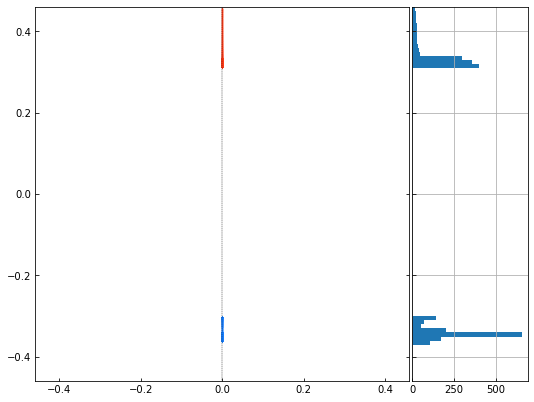

In [186]:
# Projection over the separatrix
proj_e = [(x.real*mediatrix.real + x.imag*mediatrix.imag)[0] for x in proc_out_e]
proj_g = [(x.real*mediatrix.real + x.imag*mediatrix.imag)[0] for x in proc_out_g]

left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.005ax_scatter.scatter([0]*len(proj_g), proj_g, s = 0.1,  c = '#FF3A17')
​
binwidth = 0.01
lim = np.ceil(np.abs(proj_e + proj_g).max() / binwidth) * binwidth


rect_scatter = [left, bottom, width, height]
rect_histy = [left + width + spacing, bottom, 0.2, height]

plt.figure(figsize=(8, 8))
ax_scatter = plt.axes(rect_scatter)
ax_scatter.tick_params(direction='in', right=True)
ax_histy = plt.axes(rect_histy)
ax_histy.tick_params(direction='in', labelleft=False)

ax_scatter.plot([0,0], [1, -1], linestyle = '--', c = 'k', linewidth=0.4)
ax_scatter.scatter([0]*len(proj_e), proj_e, s = 0.1, c = '#177FFF')
ax_scatter.scatter([0]*len(proj_g), proj_g, s = 0.1,  c = '#FF3A17')

binwidth = 0.01
lim = np.ceil(np.abs(proj_e + proj_g).max() / binwidth) * binwidth
ax_scatter.set_xlim((-lim, lim))
ax_scatter.set_ylim((-lim, lim))
bins = np.arange(-lim, lim + binwidth, binwidth)

ax_histy.hist(proj_e + proj_g, bins=bins, orientation='horizontal')

ax_histy.set_ylim(ax_scatter.get_ylim())

plt.grid()
plt.show()